$$p(y_i) = \prod_{l=1}^L \mathcal{N}\left(m_{l}, w_{l}\right)^{\mathbf{c}_{k}}$$

In [1]:
using Rocket, ReactiveMP, GraphPPL
using Distributions, Random, BenchmarkTools

In [2]:
@model [ default_factorisation = MeanField() ] function gaussian_mixture_model(n)
    
    s ~ Beta(1.0, 1.0)
    
    m1 ~ NormalMeanVariance(-2.0, 1e3)
    w1 ~ GammaShapeRate(0.01, 0.01)
    
    m2 ~ NormalMeanVariance(2.0, 1e3)
    w2 ~ GammaShapeRate(0.01, 0.01)
    
    z = randomvar(n)
    y = datavar(Float64, n)
    
    for i in 1:n
        z[i] ~ Bernoulli(s)
        y[i] ~ NormalMixture(z[i], (m1, m2), (w1, w2))
    end
    
    return s, m1, w1, m2, w2, z, y
end

gaussian_mixture_model (generic function with 1 method)

In [3]:
function inference(data, n_its)
    n = length(data)
    model, (s, m1, w1, m2, w2, z, y) = gaussian_mixture_model(n);
    
    mswitch = keep(Marginal)
    mm1 = keep(Marginal)
    mm2 = keep(Marginal)
    mw1 = keep(Marginal)
    mw2 = keep(Marginal)
    
    fe = keep(Float64)
    
    m1sub = subscribe!(getmarginal(m1, IncludeAll()), mm1)
    m2sub = subscribe!(getmarginal(m2, IncludeAll()), mm2)
    w1sub = subscribe!(getmarginal(w1, IncludeAll()), mw1)
    w2sub = subscribe!(getmarginal(w2, IncludeAll()), mw2)
    switchsub = subscribe!(getmarginal(s, IncludeAll()), mswitch)
    fesub = subscribe!(score(Float64, BetheFreeEnergy(), model), fe)
    
    setmarginal!(s, vague(Beta))
    setmarginal!(m1, NormalMeanVariance(-2.0, 1e3))
    setmarginal!(m2, NormalMeanVariance(2.0, 1e3))
    setmarginal!(w1, vague(GammaShapeRate))
    setmarginal!(w2, vague(GammaShapeRate))
    
    for i in 1:n_its
        update!(y, data)
    end
    
    unsubscribe!((fesub, switchsub, m1sub, m2sub, w1sub, w2sub))
    
    return mswitch, mm1, mm2, mw1, mw2, fe
end

inference (generic function with 1 method)

In [4]:
n = 50

Random.seed!(124)

switch = [ 1/3, 2/3 ]
z      = rand(Categorical(switch), n)
y      = Vector{Float64}(undef, n)

μ1 = -10.0
μ2 = 10.0
w  = 1.777

dists = [
    Normal(μ1, sqrt(inv(w))),
    Normal(μ2, sqrt(inv(w))),
]

for i in 1:n
    y[i] = rand(dists[z[i]])
end

In [5]:
@time mswitch, mm1, mm2, mw1, mw2, fe = inference(y, 10);

 20.474337 seconds (40.56 M allocations: 2.066 GiB, 3.30% gc time, 99.84% compilation time)


In [6]:
using Plots

dim(d) = (a) -> map(r -> r[d], a)

dim (generic function with 1 method)

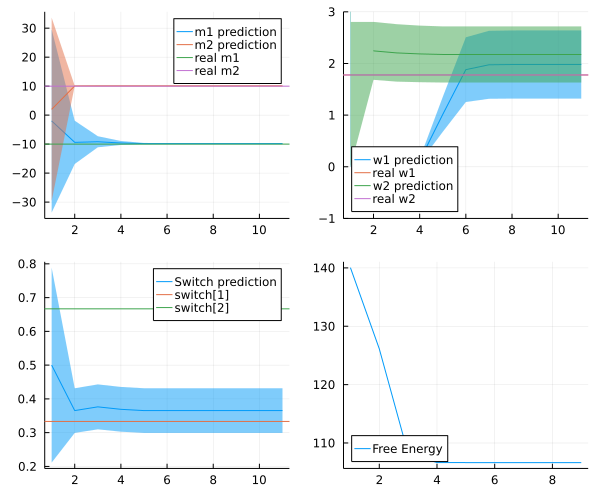

In [7]:
mp = plot(mean.(mm1), ribbon = var.(mm1) .|> sqrt, label = "m1 prediction")
mp = plot!(mean.(mm2), ribbon = var.(mm2) .|> sqrt, label = "m2 prediction")
mp = plot!(mp, [ μ1 ], seriestype = :hline, label = "real m1")
mp = plot!(mp, [ μ2 ], seriestype = :hline, label = "real m2")

wp = plot(mean.(mw1), ribbon = var.(mw1) .|> sqrt, label = "w1 prediction", legend = :bottomleft, ylim = (-1, 3))
wp = plot!(wp, [ w ], seriestype = :hline, label = "real w1")
wp = plot!(wp, mean.(mw2), ribbon = var.(mw2) .|> sqrt, label = "w2 prediction")
wp = plot!(wp, [ w ], seriestype = :hline, label = "real w2")

swp = plot(mean.(mswitch), ribbon = var.(mswitch) .|> sqrt, label = "Switch prediction")

swp = plot!(swp, [ switch[1] ], seriestype = :hline, label = "switch[1]")
swp = plot!(swp, [ switch[2] ], seriestype = :hline, label = "switch[2]")

fep = plot(fe[2:end], label = "Free Energy", legend = :bottomleft)

plot(mp, wp, swp, fep, layout = @layout([ a b; c d ]), size = (600, 500))

In [8]:
@benchmark inference($y, 10)

BenchmarkTools.Trial: 544 samples with 1 evaluation.
 Range (min … max):  6.761 ms … 23.575 ms  ┊ GC (min … max):  0.00% … 55.64%
 Time  (median):     8.131 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   9.201 ms ±  3.480 ms  ┊ GC (mean ± σ):  10.74% ± 15.85%

   █▄▃▃▁▁▂                                                    
  ▅████████▇▅▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▃▃▂▃▃▃▂▃▃▂ ▃
  6.76 ms        Histogram: frequency by time        21.3 ms <

 Memory estimate: 6.55 MiB, allocs estimate: 100699.